# Evaluate each possible single mutation using zero shot methods

In [1]:
from aide_predict.utils.common import get_supported_tools

In [3]:
get_supported_tools()

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


ProteinModelWrapper: AVAILABLE
HMMWrapper: AVAILABLE
ESM2LikelihoodWrapper: AVAILABLE
MSATransformerLikelihoodWrapper: AVAILABLE
ESM2Embedding: AVAILABLE
OneHotAlignedEmbedding: AVAILABLE
OneHotProteinEmbedding: AVAILABLE
MSATransformerEmbedding: AVAILABLE



'ProteinModelWrapper: AVAILABLE\nHMMWrapper: AVAILABLE\nESM2LikelihoodWrapper: AVAILABLE\nMSATransformerLikelihoodWrapper: AVAILABLE\nESM2Embedding: AVAILABLE\nOneHotAlignedEmbedding: AVAILABLE\nOneHotProteinEmbedding: AVAILABLE\nMSATransformerEmbedding: AVAILABLE\n'

Currently available methods:
1. ESM2
2. HMM (requires MSA)
3. MSATransformer (requires MSA)

## Here we use kinase EnvZ
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10160972/

For demo purposes, a small MSA was created using HHfilter from the EnvZ MSA.

To produce your own MSA for zero shot prediction methods that require it, you can use the [EVCouplings pipeline](https://github.com/debbiemarkslab/EVcouplings), which is a dependancy of `aide_predict` and can be imported as `from evcouplings.align.protocol import  standard as evcouplings_pipeline` and run locally. You may also use any other MSA server like jackhmmer or psi-blast on EBI or NCBI.

In [19]:
import os
import pandas as pd

from aide_predict.utils.data_structures import ProteinSequence, ProteinSequencesOnFile
from aide_predict.bespoke_models import MSATransformerLikelihoodWrapper, ESM2LikelihoodWrapper

### Define the wild type sequence and the MSA

In [5]:
wt = ProteinSequence("LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGYLAESINKDIEECNAIIEQFIDYLR", id='wt')
msa = ProteinSequencesOnFile.from_fasta(os.path.join('data', 'ENVZ_ECOLI_extreme_filtered.a2m'))

### Define and fit the model

Use MSA transformer with the wild type marginal, see [here](http://biorxiv.org/lookup/doi/10.1101/2021.07.09.450648).

__PLEASE NOTE THE DEVICE PARAMETER__: This notebook was written on apple silico so I use MPS, if you have a GPU change it to `cuda`. If you have no vector hardware, you have to use `cpu` ... good luck out there.

In [6]:
model = MSATransformerLikelihoodWrapper(
    pool=True, # we want the scores to be averaged over the whole protein
    metadata_folder='tmp', # required for the API, but MSATransformer does not use it
    wt=wt,
    marginal_method='wildtype_marginal',
    device="mps"
)
model.fit(msa)

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


MSATransformerLikelihoodWrapper(device='mps',
                                marginal_method='wildtype_marginal',
                                metadata_folder='tmp')

### Get a saturation mutagensis dataset

In [7]:
variants = wt.saturation_mutagenesis()

In [8]:
variants

ProteinSequences(count=1140, aligned=True, fixed_length=True)

### Make predictions

In [9]:
predictions = model.predict(variants)

MSA batches: 80it [00:48,  1.66it/s]00<?, ?it/s]
Sequences: 100%|██████████| 1/1 [00:48<00:00, 48.31s/it]


### Combine and sort data

In [10]:
data = {
    'mut': [v.id for v in variants], # the id of the variant is the mutation in the form "A100C"
    'variant': [str(v) for v in variants],
    'prediction': predictions.flatten()
}
data = pd.DataFrame(data)

In [11]:
data = data.sort_values('prediction', ascending=False)

In [12]:
data

,mut,variant,prediction
895,C48L,LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGYLAESINKDIE...,-0.676181
1104,L59S,LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGYLAESINKDIE...,-0.718940
678,Y36E,LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGELAESINKDIE...,-0.791490
1110,L59A,LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGYLAESINKDIE...,-0.832596
904,C48M,LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGYLAESINKDIE...,-1.208352
...,...,...,...
290,L16R,LADDRTLLMAGVSHDRRTPLTRIRLATEMMSEQDGYLAESINKDIE...,-15.006770
301,L16K,LADDRTLLMAGVSHDKRTPLTRIRLATEMMSEQDGYLAESINKDIE...,-15.481418
297,L16E,LADDRTLLMAGVSHDERTPLTRIRLATEMMSEQDGYLAESINKDIE...,-15.570413
361,L20D,LADDRTLLMAGVSHDLRTPDTRIRLATEMMSEQDGYLAESINKDIE...,-15.647059


<Axes: ylabel='Frequency'>

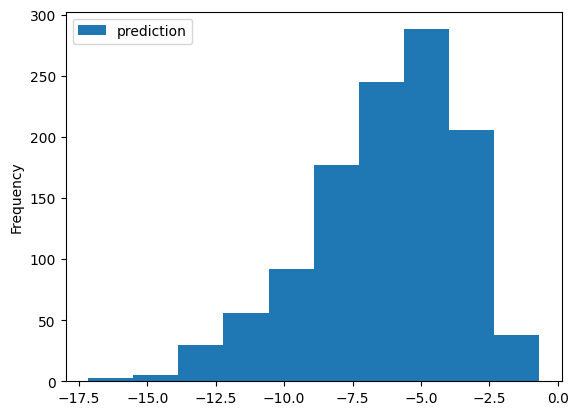

In [13]:
data.plot.hist()

Higher is better - it may be worth limitting the number of mutations in a library to the top 10% of predictions.

### EXTRA: since this protein was the subject of a DMS, we can compare to true experimental values

In [16]:
import seaborn as sns

In [14]:
labels = pd.read_csv(os.path.join('data', 'ENVZ_ECOLI_Ghose_2023.csv'))

In [15]:
data = labels.set_index('mutant').join(data.set_index('mut'))

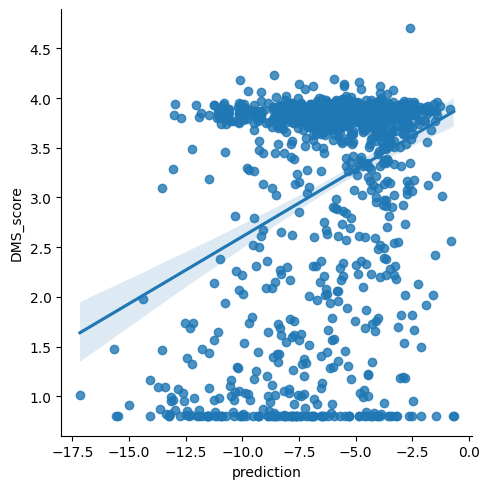

In [18]:
sns.lmplot(x='prediction', y='DMS_score', data=data)

### BONUS: Try rerunning the norebook except swap out MSATransformer with ESM2! It is the same API!